In [1]:
import nbragg

In [17]:
data = nbragg.Data.from_transmission("Fe_13733003.exfor.txt")
data.table["trans"] = 1./data.table["trans"]

<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

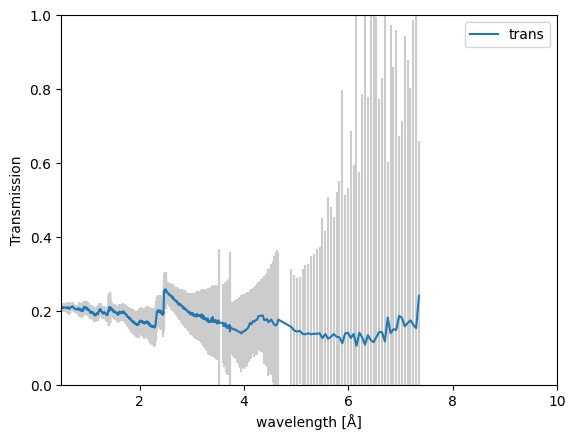

In [25]:
data.plot()

In [19]:
gamma = nbragg.CrossSection.from_material(nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection.from_material(nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

In [20]:
model = nbragg.TransmissionModel(alpha,background="polynomial3",vary_background=True,vary_response=True)

In [21]:
model.params

name,value,initial value,min,max,vary
thickness,1.00000000,None,-inf,inf,True
norm,1.00000000,None,-inf,inf,True
α1,3.67000000,3.67,-inf,inf,True
β1,3.06000000,3.06,-inf,inf,True
b0,0.00000000,0.0,-inf,inf,True
b1,0.00000000,0.0,-inf,inf,True
b2,0.00000000,0.0,-inf,inf,True


In [22]:
result = model.fit(data,wlmin=1,wlmax=5)

/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:88: RuntimeWarning: divide by zero encountered in divide
  y = (alpha*sigma2+x)/(sqrt2*sigma)
/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:89: RuntimeWarning: divide by zero encountered in divide
  z = (beta*sigma2 - x)/(sqrt2*sigma)
/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:88: RuntimeWarning: divide by zero encountered in divide
  y = (alpha*sigma2+x)/(sqrt2*sigma)
/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:89: RuntimeWarning: divide by zero encountered in divide
  z = (beta*sigma2 - x)/(sqrt2*sigma)


array([<Axes: title={'center': 'Alpha-Iron'}, ylabel='Transmission'>,
       <Axes: xlabel='λ [Å]', ylabel='Residuals [1σ]'>], dtype=object)

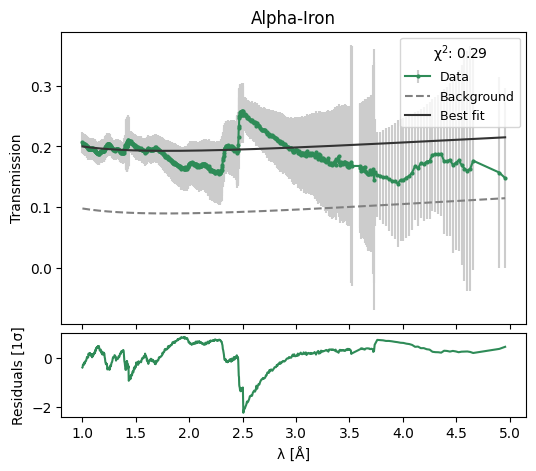

In [23]:
result.plot()

In [24]:
result

In [69]:
from urllib.request import urlopen, Request
import pandas as pd
import io

x4id = 13733002
req = Request(
        url=f'https://nds.iaea.org/exfor/x4get?DatasetID={x4id}&op=csv',
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
        }
    )
with urlopen(req) as f:
    df = pd.read_csv(io.StringIO(f.read().decode('utf-8')))
if 'EN (EV) 1.1' in list(df):
    x4_E, x4_xs = df['EN (EV) 1.1'].values, df['DATA (B) 0.1'].values
elif 'EN (MEV) 1.1' in list(df):
    x4_E, x4_xs = 1e6*df['EN (MEV) 1.1'].values, df['DATA (B) 0.1'].values

df = df[['EN (EV) 1.1',"DATA (B) 0.1",'DATA-ERR (B) 0.911']]
df.columns = ["energy", "data", "data_err"]

In [70]:
df.to_csv("Be_13733002.exfor.txt",sep=" ",header=False)

<Axes: xlabel='energy'>

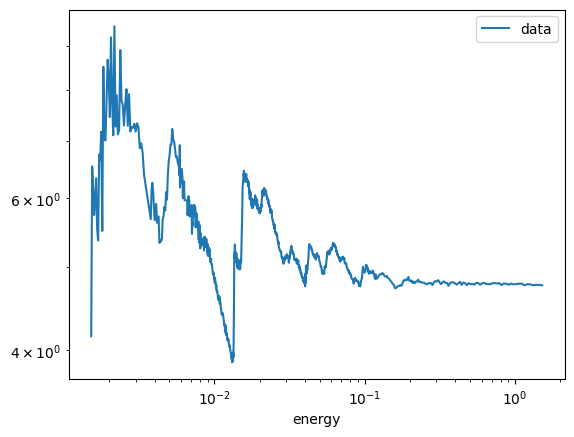

In [61]:
df.plot(x="energy",y="data",loglog=True)